# Project 14 — Numerical Modeling and Simulation: Hydrogen Diffusion on a 2D Lattice (Final Corrected Version)

This notebook provides a complete, **question-by-question implementation** (I.a → II) of the Kinetic Monte Carlo (KMC) simulations for hydrogen diffusion on a 2D lattice.




In [1]:
# %% [I.a] — Imports and utility functions
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import lstsq
import csv

%matplotlib inline

def make_rng(seed=None):
    return np.random.default_rng(seed)

def visualize_trajectory(positions, title="2D KMC Trajectory", nmax=None):
    """Display a 2D trajectory of the hydrogen atom."""
    if nmax is None or nmax > len(positions):
        nmax = len(positions)
    plt.figure(figsize=(6,6))
    plt.plot(positions[:nmax,0], positions[:nmax,1], lw=0.5, color='tab:blue')
    plt.scatter(positions[0,0], positions[0,1], color='green', s=50, label='Start')
    plt.scatter(positions[nmax-1,0], positions[nmax-1,1], color='red', s=50, label='End')
    plt.xlabel('x (a)')
    plt.ylabel('y (a)')
    plt.axis('equal')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()


In [2]:
# %% [I.a] — Classical KMC simulation
def kmc_classical(num_steps, Gamma1, Gamma2, a=1.0, seed=None):
    rng = make_rng(seed)
    Gamma = float(Gamma1) + float(Gamma2)
    if Gamma <= 0:
        raise ValueError("Γ₁ + Γ₂ must be > 0")
    dt = 1.0 / Gamma

    pos = np.zeros((num_steps + 1, 2))
    times = np.zeros(num_steps + 1)

    moves_10 = np.array([[1,0],[-1,0],[0,1],[0,-1]], dtype=float)
    moves_11 = np.array([[1,1],[-1,-1],[1,-1],[-1,1]], dtype=float)

    for n in range(num_steps):
        r = rng.random()
        move = moves_10[rng.integers(0,4)] if r < (Gamma1/Gamma) else moves_11[rng.integers(0,4)]
        pos[n+1] = pos[n] + move
        times[n+1] = times[n] + dt

    return pos * a, times


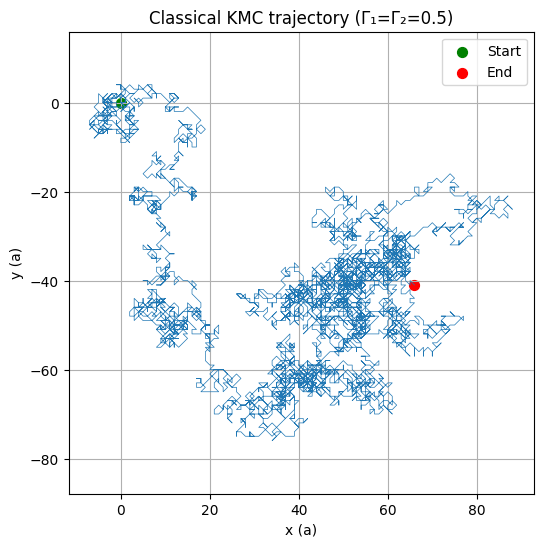

Trajectory saved to /tmp/trajectory_H_KMC.csv


In [3]:
# %% [I.b] — Generate and save a trajectory
def save_trajectory_csv(filename, positions, times):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['step','time','x','y'])
        for i in range(len(times)):
            writer.writerow([i, times[i], positions[i,0], positions[i,1]])
    print(f"Trajectory saved to {filename}")

# Example run
Nsteps = 200_000
pos, times = kmc_classical(Nsteps, Gamma1=0.5, Gamma2=0.5, a=1.0, seed=42)
visualize_trajectory(pos, "Classical KMC trajectory (Γ₁=Γ₂=0.5)", nmax=5000)
save_trajectory_csv('/tmp/trajectory_H_KMC.csv', pos, times)


Estimated D = 0.28081


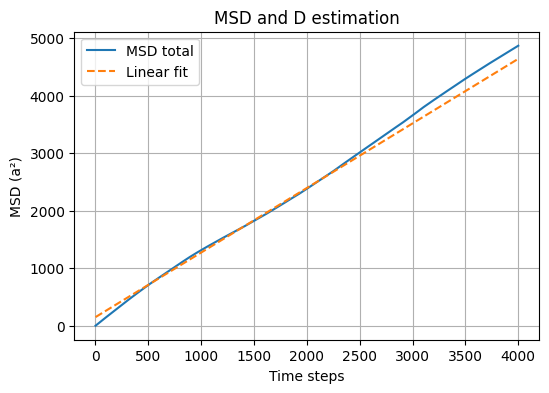

In [4]:
# %% [I.c] — MSD computation and diffusion coefficient estimation
def compute_msd_zero_offset(positions, max_lag=None):
    N = len(positions)
    if max_lag is None:
        max_lag = N // 4
    lags = np.arange(1, max_lag+1)
    msd = np.zeros_like(lags, dtype=float)
    for i, lag in enumerate(lags):
        diffs = positions[lag:] - positions[:-lag]
        msd[i] = np.mean(np.sum(diffs**2, axis=1))
    return lags, msd

def fit_diffusion_coefficient(lags, msd, Gamma1, Gamma2, fit_range=(200,2000)):
    dt = 1.0 / (Gamma1 + Gamma2)
    lo, hi = fit_range
    if hi > lags.max():
        hi = int(lags.max())
    sel = (lags >= lo) & (lags <= hi)
    A = np.vstack([lags[sel]*dt, np.ones(sel.sum())]).T
    slope, intercept = lstsq(A, msd[sel], rcond=None)[0]
    return slope/4.0, slope, intercept

lags, msd = compute_msd_zero_offset(pos, 4000)
D_sim, slope, intercept = fit_diffusion_coefficient(lags, msd, Gamma1=0.5, Gamma2=0.5)
print(f"Estimated D = {D_sim:.5f}")

plt.figure(figsize=(6,4))
plt.plot(lags, msd, label='MSD total')
plt.plot(lags, slope*(lags/(0.5+0.5)) + intercept, '--', label='Linear fit')
plt.xlabel('Time steps'); plt.ylabel('MSD (a²)')
plt.legend(); plt.grid(True)
plt.title('MSD and D estimation')
plt.show()


In [5]:
# %% [I.d - I.e] — Study of Γ₁/Γ ratios and analytical comparison
def analytic_D(Gamma1, Gamma2, d1, d2):
    return 0.25 * (Gamma1*d1**2 + Gamma2*d2**2)

ratios = [0.25, 0.75]
a = 1.0
d1, d2 = a, math.sqrt(2)*a
results = []

for frac in ratios:
    G1 = frac
    G2 = 1 - frac
    pos_tmp, _ = kmc_classical(200_000, G1, G2, a=1.0, seed=123+int(frac*100))
    lags_tmp, msd_tmp = compute_msd_zero_offset(pos_tmp, 3000)
    D_tmp, _, _ = fit_diffusion_coefficient(lags_tmp, msd_tmp, G1, G2)
    D_anal = analytic_D(G1, G2, d1, d2)
    results.append((frac, D_tmp, D_anal))

for frac, D_tmp, D_anal in results:
    print(f"Γ₁/Γ = {frac:.2f} → D_sim = {D_tmp:.6f}, D_anal = {D_anal:.6f}, rel. error = {(D_tmp-D_anal)/D_anal:.2%}")


Γ₁/Γ = 0.25 → D_sim = 0.411076, D_anal = 0.437500, rel. error = -6.04%
Γ₁/Γ = 0.75 → D_sim = 0.281129, D_anal = 0.312500, rel. error = -10.04%


In [6]:
# %% [II] — Modified KMC model (with rotations around oxygen sites)
def kmc_modified_with_O(num_steps, Gamma_trans, Gamma_rot, a=1.0, b=0.25, seed=None):
    rng = make_rng(seed)
    Gamma = Gamma_trans + Gamma_rot
    if Gamma <= 0:
        raise ValueError("Γ_trans + Γ_rot must be > 0")
    dt = 1.0 / Gamma

    pos_H = np.zeros((num_steps + 1, 2))
    pos_O = np.zeros((num_steps + 1, 2))
    times = np.zeros(num_steps + 1)

    O = np.array([0.0, 0.0])
    H = O + np.array([b, 0.0])
    pos_H[0] = H; pos_O[0] = O

    moves = np.array([[1,0],[-1,0],[0,1],[0,-1]])
    prob_trans = Gamma_trans / Gamma

    for n in range(num_steps):
        if rng.random() < prob_trans and Gamma_trans > 0:
            dir_vec = moves[rng.integers(0,4)]
            rel = pos_H[n] - pos_O[n]
            O = O + dir_vec * a
            H = O + rel  # preserve relative position
        else:
            angle = math.pi/2 if rng.random() < 0.5 else -math.pi/2
            rel = pos_H[n] - pos_O[n]
            R = np.array([[math.cos(angle), -math.sin(angle)],[math.sin(angle), math.cos(angle)]])
            H = pos_O[n] + R.dot(rel)
        pos_H[n+1] = H
        pos_O[n+1] = O
        times[n+1] = times[n] + dt
    return pos_H, times, pos_O


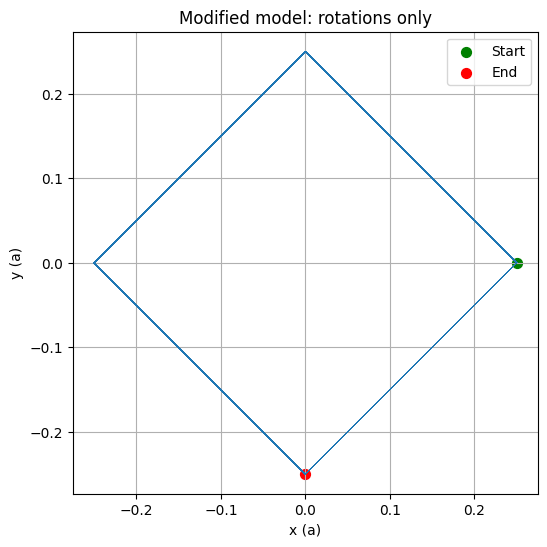

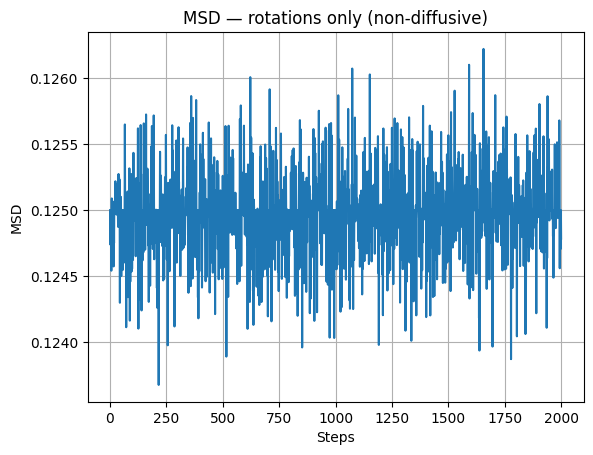

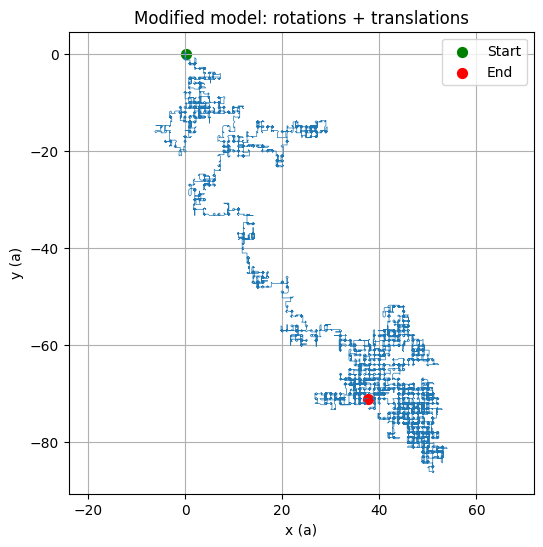

D_sim (modified) = 0.053348, D_anal = 0.037500, rel. error = 42.26%


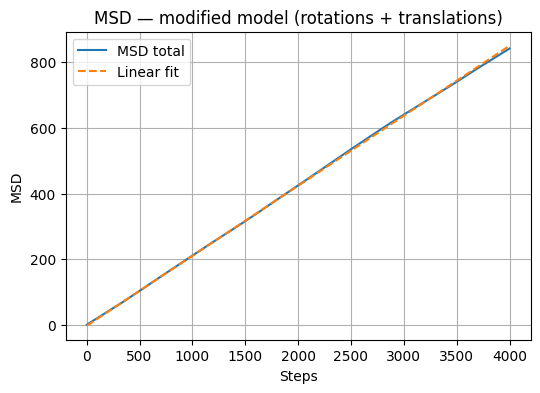

In [7]:
# %% [II] — Modified model analysis
# Case 1: rotations only (non-diffusive)
pos_H_rot, t_rot, _ = kmc_modified_with_O(100_000, Gamma_trans=0, Gamma_rot=1.0, a=1.0, b=0.25, seed=1)
visualize_trajectory(pos_H_rot, "Modified model: rotations only", nmax=10000)
lags_r, msd_r = compute_msd_zero_offset(pos_H_rot, 2000)
plt.plot(lags_r, msd_r)
plt.title('MSD — rotations only (non-diffusive)')
plt.xlabel('Steps'); plt.ylabel('MSD')
plt.grid(True)
plt.show()

# Case 2: translations + rotations (diffusive)
pos_H_mix, t_mix, _ = kmc_modified_with_O(200_000, Gamma_trans=0.2, Gamma_rot=0.8, a=1.0, b=0.25, seed=2)
visualize_trajectory(pos_H_mix, "Modified model: rotations + translations", nmax=10000)
lags_m, msd_m = compute_msd_zero_offset(pos_H_mix, 4000)
D_mix, slope_m, inter_m = fit_diffusion_coefficient(lags_m, msd_m, 0.2, 0.8)
d1_eff, d2_eff = 1.0 - 2*0.25, math.sqrt(2)*0.25
D_anal2 = analytic_D(0.2, 0.8, d1_eff, d2_eff)

print(f"D_sim (modified) = {D_mix:.6f}, D_anal = {D_anal2:.6f}, rel. error = {(D_mix-D_anal2)/D_anal2:.2%}")

plt.figure(figsize=(6,4))
plt.plot(lags_m, msd_m, label='MSD total')
plt.plot(lags_m, slope_m*(lags_m/(0.2+0.8)) + inter_m, '--', label='Linear fit')
plt.xlabel('Steps'); plt.ylabel('MSD')
plt.title('MSD — modified model (rotations + translations)')
plt.legend(); plt.grid(True)
plt.show()


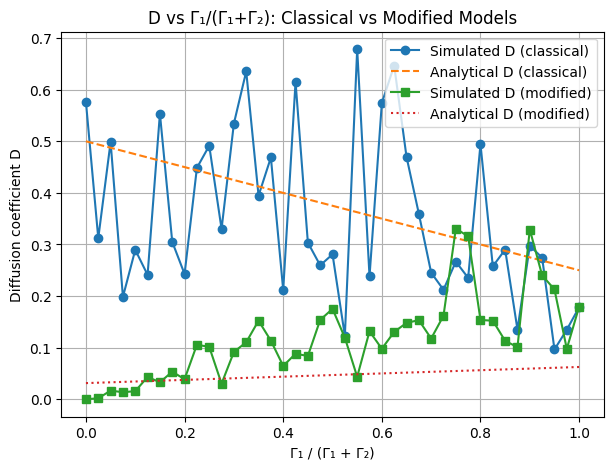

In [15]:
# %% [III] — Plot D vs Gamma1 for both classical and modified models
def plot_D_vs_Gamma1(num_steps=10_000, a=1.0, b=0.25):
    ratios = np.linspace(0, 1, 41)
    D_classical, D_modified, D_anal_classical, D_anal_mod = [], [], [], []

    d1, d2 = a, math.sqrt(2)*a
    d1m, d2m = a - 2*b, math.sqrt(2)*b

    for frac in ratios:
        G1, G2 = frac, 1 - frac
        # Classical
        pos_c, _ = kmc_classical(num_steps, G1, G2, a=a, seed=100+int(frac*100))
        lags_c, msd_c = compute_msd_zero_offset(pos_c, 2000)
        D_c, _, _ = fit_diffusion_coefficient(lags_c, msd_c, G1, G2)
        D_classical.append(D_c)
        D_anal_classical.append(analytic_D(G1, G2, d1, d2))
        # Modified
        pos_m, _, _ = kmc_modified_with_O(num_steps, G1, G2, a=a, b=b, seed=200+int(frac*100))
        lags_m, msd_m = compute_msd_zero_offset(pos_m, 2000)
        D_m, _, _ = fit_diffusion_coefficient(lags_m, msd_m, G1, G2)
        D_modified.append(D_m)
        D_anal_mod.append(analytic_D(G1, G2, d1m, d2m))

    plt.figure(figsize=(7,5))
    plt.plot(ratios, D_classical, 'o-', label='Simulated D (classical)')
    plt.plot(ratios, D_anal_classical, '--', label='Analytical D (classical)')
    plt.plot(ratios, D_modified, 's-', label='Simulated D (modified)')
    plt.plot(ratios, D_anal_mod, ':', label='Analytical D (modified)')
    plt.xlabel('Γ₁ / (Γ₁ + Γ₂)')
    plt.ylabel('Diffusion coefficient D')
    plt.title('D vs Γ₁/(Γ₁+Γ₂): Classical vs Modified Models')
    plt.grid(True)
    plt.legend()
    plt.show()

# Run comparison
plot_D_vs_Gamma1()
